**Import Packages**

In [ ]:
# Model Training and preprocessing libraries
# Model Training and preprocessing libraries
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB

#########!!!!!!!!! Performance evaluation libraries

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

from google.colab import drive

**Read Datasets**

In [ ]:
drive.mount('/content/drive')

dfMain = pd.read_csv('/content/drive/MyDrive/ML Midterm/Datasets/main_dataset.csv')

Mounted at /content/drive


**Data Exploration**


In [ ]:

dfMain.drop(columns = ['is_playable', 'track_uri', 'name', 'artists_names', 'artists_uris', 'playlist_uris', 'analysis_url','release_date'], inplace = True)

# Remap album_type to be able to be interpreted as an integer
dfMain['album_type'] = dfMain['album_type'].replace(to_replace = ['single', 'album', 'compilation'], value = range(3))

# Create new Column to be able to display popularity as a binary value
dfMain['popular'] = [0] * dfMain.shape[0]
cutoff = dfMain['popularity'].mean()
dfMain['popular'] = dfMain['popularity'].apply(lambda x : x >= cutoff)
dfMain['popular'] = dfMain['popularity'].apply(lambda x : x <= 8 or x >= 44)


#Takes the top 25% and the bottom 25%. Values that are in the top 25% are True and values in the bottom 25% are false.
df = dfMain[dfMain['popular'] == True]
dftop25 = dfMain[dfMain['popularity'] <= 8]
dftop25['popular'] = True
dfbot25 = dfMain[dfMain['popularity'] >= 44]
dfbot25['popular'] = False
df = pd.concat([dftop25, dfbot25])

#Remap the artists_popularities to use the average instead of a list
dfMain['artists_popularities'] = dfMain['artists_popularities'].apply(lambda x : sum([int(i) for i in x[1:len(x) - 1].split(',')]) / len(x))

<ipython-input-3-8908d794528d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftop25['popular'] = True
<ipython-input-3-8908d794528d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbot25['popular'] = False


In [ ]:

columns = ['key', 'loudness', 'tempo', 'duration_ms', 'time_signature']
for i in columns:
  mean, std = [dfMain[i].mean(), dfMain[i].std()]
  dfMain[i] = dfMain[i].apply(lambda x : (x - mean) / std)

dfMain

,popularity,album_type,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artists_popularities,artists_genres,artists_followers,popular
0,0,0,0.611,0.614,-0.066600,0.232111,0,0.0672,0.01690,0.000794,0.7530,0.520,0.290655,-0.319979,0.260323,3.000,[[]],[765],True
1,33,1,0.638,0.781,-0.347765,0.526923,0,0.0285,0.01180,0.009530,0.3490,0.250,0.124383,-0.323042,0.260323,15.500,"[['etherpop', 'pop', 'r&b'], ['chillstep', 'fu...","[1283665, 138396]",False
2,52,0,0.560,0.810,-1.472423,0.349916,0,0.0872,0.00710,0.000008,0.2410,0.247,1.669213,-0.127348,0.260323,16.250,"[['detroit hip hop', 'pop r&b', 'r&b', 'trap',...",[1544981],True
3,0,0,0.525,0.699,1.058058,0.868197,1,0.0353,0.01780,0.000088,0.0888,0.199,-0.892416,1.800448,0.260323,8.000,"[['shimmer pop', 'shiver pop']]",[18241],True
4,0,0,0.367,0.771,1.058058,0.674553,1,0.1060,0.36500,0.000001,0.0965,0.163,-0.107641,-0.056613,0.260323,8.625,"[['indie poptimism'], ['la pop']]","[10105, 13775]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277933,54,2,0.777,0.725,-0.066600,0.202585,1,0.0470,0.12600,0.010800,0.0917,0.851,0.300470,0.374320,0.260323,17.500,"[['classic rock', 'folk', 'folk rock', 'mellow...",[2065865],True
277934,0,1,0.543,0.482,-0.347765,-0.363508,1,0.1940,0.08530,0.000092,0.1110,0.415,2.439642,0.446113,0.260323,15.750,"[['german pop', 'german rock', 'new wave pop']]",[365584],True
277935,77,1,0.527,0.942,-1.191259,0.707976,0,0.0366,0.01150,0.000000,0.1880,0.495,0.969298,0.075189,0.260323,19.000,"[['classic rock', 'heartland rock', 'mellow go...",[5478543],True
277936,74,2,0.768,0.829,-0.066600,0.787562,1,0.0313,0.09640,0.000029,0.0970,0.962,-0.013886,0.015676,0.260323,16.250,"[['album rock', 'classic rock', 'mellow gold',...",[1424479],True


<Axes: xlabel='popularity'>

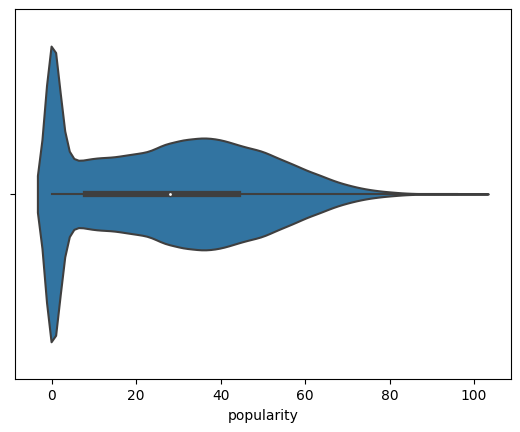

In [ ]:
sns.violinplot(x="popularity", data = dfMain)
#most songs are rated w a popularity of 0
#majority of the songs that aren't 0 lie in the range of 30-60

<Axes: xlabel='liveness', ylabel='Count'>

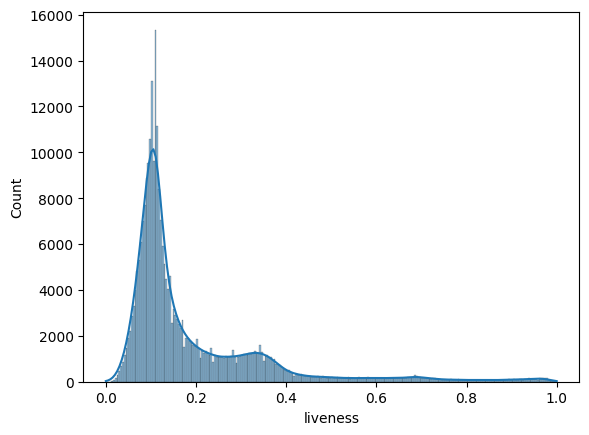

In [ ]:
sns.histplot(kde=True, data = dfMain, x = "liveness")
#this graph shows most songs are in between the range of 0 to 0.2

<Axes: xlabel='popular', ylabel='danceability'>

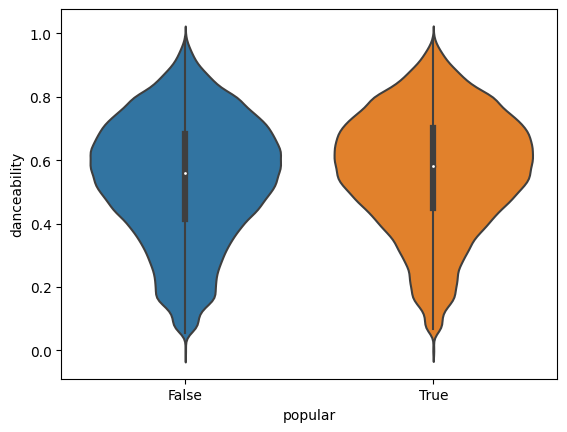

In [ ]:
# These values were chosen as it shows how
# danceability does have an influence
# on popularity. They also show how danceability
# does not affect the popularity too much.
sns.violinplot(data = dfMain, x = 'popular', y = 'danceability')

<Axes: xlabel='popular', ylabel='liveness'>

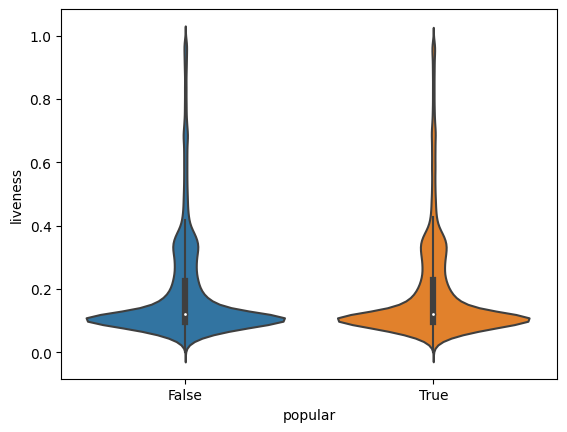

In [ ]:
# This graph was chosen to see if there were any correlation between
# popularity and liveness. This

sns.violinplot(kde=True, data = dfMain, x = 'popular', y = "liveness")

<Axes: xlabel='loudness', ylabel='energy'>

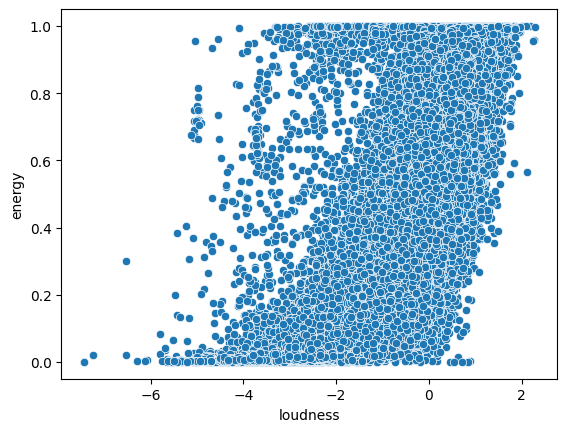

In [ ]:
sns.scatterplot(y="energy", x = "loudness", data = dfMain)
#The correlation between energy and loudness
#for certain songs as loudness increases the energy increases
#but for the majority of the songs thers no coorelation


**Data Visualization**

In [ ]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
y = dfMain['popular']
X = dfMain.drop(columns = ['popular', 'popularity', 'artists_genres', 'artists_followers'])
#slip data into test and train
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
clf_tree = DecisionTreeClassifier(max_depth = 10)
clf_tree.fit(X_train, y_train)
pred_tree = clf_tree.predict(X_test)


In [ ]:
#Cross validating the decision tree
scoring = ['f1', 'accuracy', 'precision', 'recall']
k = 5

cv_results = cross_validate(estimator = clf_tree, X = X, y = y, cv = k, scoring = scoring)
#Confusion Matrix:

cMatrix = confusion_matrix(pred_tree,y_test, labels = [1, 0])

#prints info

print(f'Decision Tree:',
        f'Confusion Matrix:\n',
        f'Displayed as:',
        f'TP               FP',
        f'FN               TN\n',
        f'{cMatrix[0][0]}          {cMatrix[0][1]}',
        f'{cMatrix[1][0]}            {cMatrix[1][1]}',
        f'\nOther Info:',
        f'              AVG            STD',
        f'F1 Score:    {round(cv_results["test_f1"].mean() * 100, 2)}%       {round(cv_results["test_f1"].std() * 100, 4)}%',
        f'Accuracy:    {round(cv_results["test_accuracy"].mean() * 100, 2)}%       {round(cv_results["test_accuracy"].std() * 100, 4)}%',
        f'Precision:   {round(cv_results["test_precision"].mean()* 100, 2)}%       {round(cv_results["test_precision"].std() * 100, 4)}%',
        f'Recall:      {round(cv_results["test_recall"].mean() * 100, 2)}%       {round(cv_results["test_recall"].std() * 100, 4)}%',
        sep = '\n')

Decision Tree:
Confusion Matrix:

Displayed as:
TP               FP
FN               TN

17866          8302
10875            18545

Other Info:
              AVG            STD
F1 Score:    62.85%       4.2275%
Accuracy:    64.13%       2.212%
Precision:   66.97%       2.0353%
Recall:      59.68%       7.3827%


In [ ]:
#Gaussian Naive Bayes classifier
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)
pred_gnb = clf_gnb.predict(X_test)

In [ ]:
#Cross validating the Gaussian Naive Bayes
scoring = ['f1', 'accuracy', 'precision', 'recall']
k = 5

cv_results = cross_validate(estimator = clf_gnb, X = X, y = y, cv = k, scoring = scoring)
#Confusion Matrix:

cMatrix = confusion_matrix(pred_gnb,y_test, labels = [1, 0])

#prints info

print(f'Gaussian Naive Bayes:',
        f'Confusion Matrix:\n',
        f'Displayed as:',
        f'TP               FP',
        f'FN               TN\n',
        f'{cMatrix[0][0]}          {cMatrix[0][1]}',
        f'{cMatrix[1][0]}            {cMatrix[1][1]}',
        f'\nOther Info:',
        f'              AVG            STD',
        f'F1 Score:    {round(cv_results["test_f1"].mean() * 100, 2)}%       {round(cv_results["test_f1"].std() * 100, 4)}%',
        f'Accuracy:    {round(cv_results["test_accuracy"].mean() * 100, 2)}%       {round(cv_results["test_accuracy"].std() * 100, 4)}%',
        f'Precision:   {round(cv_results["test_precision"].mean()* 100, 2)}%       {round(cv_results["test_precision"].std() * 100, 4)}%',
        f'Recall:      {round(cv_results["test_recall"].mean() * 100, 2)}%       {round(cv_results["test_recall"].std() * 100, 4)}%',
        sep = '\n')

Gaussian Naive Bayes:
Confusion Matrix:

Displayed as:
TP               FP
FN               TN

20004          14829
8737            12018

Other Info:
              AVG            STD
F1 Score:    62.55%       2.6168%
Accuracy:    57.61%       3.1325%
Precision:   57.32%       2.7786%
Recall:      68.98%       3.9027%


In [ ]:
# logistic regression classifier
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf_reg = LogisticRegression()
clf_reg.fit(X_train, y_train)
pred_reg = clf_reg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#Cross validating the Logistic Regression
scoring = ['f1', 'accuracy', 'precision', 'recall']
k = 5

cv_results = cross_validate(estimator = clf_reg, X = X, y = y, cv = k, scoring = scoring)
#Confusion Matrix:

cMatrix = confusion_matrix(pred_reg,y_test, labels = [1, 0])

#prints info

print(f'Logistic Regression:',
        f'Confusion Matrix:\n',
        f'Displayed as:',
        f'TP               FP',
        f'FN               TN\n',
        f'{cMatrix[0][0]}          {cMatrix[0][1]}',
        f'{cMatrix[1][0]}            {cMatrix[1][1]}',
        f'\nOther Info:',
        f'              AVG            STD',
        f'F1 Score:    {round(cv_results["test_f1"].mean() * 100, 2)}%        {round(cv_results["test_f1"].std() * 100, 4)}%',
        f'Accuracy:    {round(cv_results["test_accuracy"].mean() * 100, 2)}%       {round(cv_results["test_accuracy"].std() * 100, 4)}%',
        f'Precision:   {round(cv_results["test_precision"].mean()* 100, 2)}%       {round(cv_results["test_precision"].std() * 100, 4)}%',
        f'Recall:      {round(cv_results["test_recall"].mean() * 100, 2)}%       {round(cv_results["test_recall"].std() * 100, 4)}%',
        sep = '\n')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression:
Confusion Matrix:

Displayed as:
TP               FP
FN               TN

17652          12654
11089            14193

Other Info:
              AVG            STD
F1 Score:    59.02%        4.4904%
Accuracy:    56.91%       2.6939%
Precision:   57.47%       1.9886%
Recall:      61.02%       7.9378%


In [ ]:
#comparing prediction to result
print((pred_tree == y_test).sum()/len(pred_tree))
print((pred_gnb == y_test).sum()/len(pred_gnb))
print((pred_reg == y_test).sum()/len(pred_reg))

0.6550154709649565
0.5760595812045766
0.5728754407426063
